In [23]:
# If you use google drive to store model
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [24]:
ls /gdrive/MyDrive/models/

 archive/  'A_Z Handwritten Data.csv'


In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np

In [5]:
from tensorflow.keras.datasets import mnist
import numpy as np
import tensorflow as tf

##Load MNIST dataset

In [6]:
def load_mnist_dataset():
	((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
	data = np.vstack([trainData, testData])
	labels = np.hstack([trainLabels, testLabels])
	# return a 2-tuple of the MNIST data and labels
	return (data, labels)

In [7]:
import matplotlib
matplotlib.use("Agg")

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [9]:
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow

In [10]:
EPOCHS = 16
INIT_LR = 1e-1
BS = 128

In [12]:
# A-sample1

In [ ]:
"""label[0]=A
images[0]=A"""

##Load A-Z Handwritten dataset
link of the dataset  :-

In [13]:
def load_az_dataset(datasetPath):
  data = []
  labels = []
  for row in open(datasetPath):
    row = row.split(",")
    label = int(row[0])
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    image = image.reshape((28, 28))
    data.append(image)
    labels.append(label)
  data = np.array(data, dtype='float32')
  labels = np.array(labels, dtype="int")
  return (data, labels)

In [14]:
(digitsData, digitsLabels) = load_mnist_dataset()
(azData, azLabels) = load_az_dataset('/gdrive/MyDrive/models/A_Z Handwritten Data.csv')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
digitsData[0].shape
azData[0].shape

(28, 28)

In [16]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every
# A-Z label to ensure the A-Z characters are not incorrectly labeled
# as digits
# azLabels += 10
# stack the A-Z data and labels with the MNIST digits data and labels
# data = np.vstack([azData, digitsData])
data = np.vstack([digitsData])
# labels = np.hstack([azLabels, digitsLabels])
labels = np.hstack([digitsLabels])
# each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# however, the architecture we're using is designed for 32x32 images,
# so we need to resize them to 32x32
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

In [17]:
# convert the labels from integers to vectors
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

##Data Augmentation

In [18]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.05,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	fill_mode="nearest")


##Building Resnet Architecture

In [19]:
import tensorflow.keras as keras

In [20]:
print(tf.__version__)

2.18.0


In [21]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

In [22]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print(model.summary())

[INFO] compiling model...


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "resnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 1)      │              4 │ input_layer[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            576 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 16)     │          1,024 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 16)     │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 16)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 16)     │          2,304 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 32, 16)     │             64 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 16)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          1,024 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │          4,096 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 32, 32, 64)     │            256 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)    

 Total params: 320,462 (1.22 MB)

 Trainable params: 316,300 (1.21 MB)

 Non-trainable params: 4,162 (16.26 KB)

None


In [25]:
import os
checkpoint_path = "az_dg_cp_1.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [27]:
model.load_weights('/content/OCR_Resnet_16.h5')

##Fit the model

In [28]:
print("[INFO] training network...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS,
	class_weight=classWeight,
	verbose=1)

[INFO] training network...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 1388s 3s/step - accuracy: 0.9938 - loss: 0.1876 - val_accuracy: 0.9884 - val_loss: 0.1975
Epoch 2/16
  1/437 ━━━━━━━━━━━━━━━━━━━━ 32:14 4s/step - accuracy: 1.0000 - loss: 0.1714

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


437/437 ━━━━━━━━━━━━━━━━━━━━ 86s 188ms/step - accuracy: 1.0000 - loss: 0.1714 - val_accuracy: 0.9916 - val_loss: 0.1885
Epoch 3/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 1408s 3s/step - accuracy: 0.9943 - loss: 0.1820 - val_accuracy: 0.9933 - val_loss: 0.1808
Epoch 4/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 86s 188ms/step - accuracy: 0.9922 - loss: 0.1942 - val_accuracy: 0.9868 - val_loss: 0.2010
Epoch 5/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 1450s 3s/step - accuracy: 0.9941 - loss: 0.1797 - val_accuracy: 0.9909 - val_loss: 0.1877
Epoch 6/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 84s 188ms/step - accuracy: 0.9844 - loss: 0.1904 - val_accuracy: 0.9921 - val_loss: 0.1835
Epoch 7/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 1361s 3s/step - accuracy: 0.9943 - loss: 0.1761 - val_accuracy: 0.9942 - val_loss: 0.1702
Epoch 8/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 85s 188ms/step - accuracy: 1.0000 - loss: 0.1542 - val_accuracy: 0.9944 - val_loss: 0.1697
Epoch 9/16
437/437 ━━━━━━━━━━━━━━━━━━━━ 1387s 3s/step - accuracy: 0.9951 - loss: 0.1704 - val_acc

##Evaluate model

In [30]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
110/110 ━━━━━━━━━━━━━━━━━━━━ 62s 558ms/step


ValueError: Number of classes, 10, does not match size of target_names, 36. Try specifying the labels parameter

##Save model

In [31]:
model.save('OCR_Resnet_16_number_alphabet.h5',save_format=".h5")

##Load model

In [32]:
# save the model to disk
print("[INFO] serializing network...")
#model.save('first_model', save_format="h5")
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('plot')

[INFO] serializing network...


In [33]:
output = ""

##Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

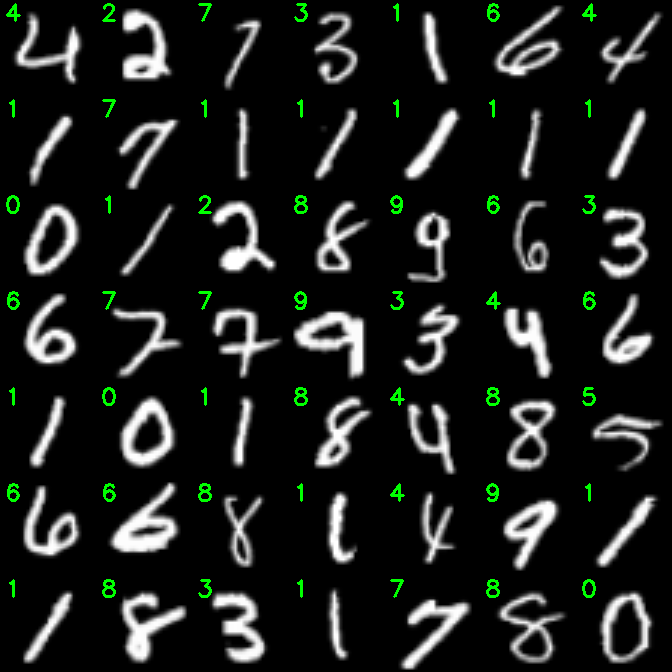

-1

In [34]:
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(256,)):
  probs = model.predict(testX[np.newaxis, i])
  prediction = probs.argmax(axis=1)
  label = labelNames[prediction[0]]
  output+=label
  image = (testX[i] * 255).astype("uint8")
  color = (0, 255, 0)
  if prediction[0] != np.argmax(testY[i]):
    color = (0, 0, 255)
  image = cv2.merge([image] * 3)
  image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
  cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
  images.append(image)
montage = build_montages(images, (96, 96), (7, 7))[0]
cv2_imshow(montage)
cv2.waitKey(0)


In [35]:
output

'4273164171111101289636779346101848566814911831780471750813992115427992924297818888472353891317074148799230127286718371685207820730577350145755568926754423032779205497416992343675799354656135338405281835028374463811588467914012042035701141469984955115055142'